In [1]:
import numpy as np
import os
from qcodes import Station
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.plotting import plot_dataset
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.logger.logger import start_all_logging
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
import matplotlib.pyplot as plt
import scipy.signal as sp
from lab_qcodes import *

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200511-46392-qcodes.log


In [2]:
# Sempre importante iniciar o logging
start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200511-46392-qcodes.log


# Teste

In [3]:
PSG1 = DummySignalGenerator("SignalGenerator1",noise_function=np.zeros)
PSG2 = DummySignalGenerator("SignalGenerator2",noise_function=np.zeros)
PSG3 = DummySignalGenerator("SignalGenerator3",noise_function=np.zeros)
osc = DummyOscilloscope('oscilloscope')


In [4]:
aDUT = DUT("DUT",PSG1)
circuit = HomodyneCircuit("circuit",aDUT,PSG2)
circuit2 = HomodyneCircuit("circuit2",PSG1,PSG2)

In [7]:
circuit2.fc(50)

In [17]:
osc.ch1.n_points(2500)
osc.ch2.n_points(2500)
osc.ch3.n_points(2500)
osc.ch4.n_points(2500)

osc.ch1.connect_inst(aDUT)
osc.ch2.connect_inst(PSG2)
osc.ch3.connect_inst(circuit)
osc.ch4.connect_inst(circuit2)
osc.ch1.t_start.set(-10)
osc.ch1.t_stop.set(10)
osc.ch2.t_start.set(-10)
osc.ch2.t_stop.set(10)
osc.ch3.t_start.set(-10)
osc.ch3.t_stop.set(10)
osc.ch4.t_start.set(-10)
osc.ch4.t_stop.set(10)


# Homodyne 

In [18]:
amp = 1
PSG1.amp(amp)
PSG2.amp(amp)

# Teste Medida 

In [19]:
# Station representa um conjunto de instrumentos
station = Station()
station.snapshot()

{'instruments': {},
 'parameters': {},
 'components': {},
 'config': None,
 'default_measurement': []}

In [20]:
station.add_component(osc)

'oscilloscope'

In [21]:
# Criar um database
initialise_or_create_database_at("~/teste.db")

In [22]:
#Definir um experimento
exp = load_or_create_experiment(experiment_name='osc_teste',
                                sample_name="osc teste 1")

In [26]:
def calculateGain():
    Y = osc.ch4.wavesample()
    n_mean = int(len(Y)/2)
    value = 2*np.mean(Y[n_mean:])
    value = 10*np.log(np.power(value,2))
    return value

gain = Parameter('gain',
                  label='gain',
                  unit='dB',
                  get_cmd=calculateGain)

In [27]:
# Medida de fato
meas = Measurement(exp=exp, station=station)

meas.register_parameter(PSG1.freq)
meas.register_parameter(gain, setpoints=[PSG1.freq])

with meas.run() as datasaver:
    for aFreq in np.linspace(1,500,500):
        PSG1.freq(aFreq)
        PSG2.freq(aFreq)
        datasaver.add_result((gain, gain()), (PSG1.freq, PSG1.freq()))
        
dataset = datasaver.dataset

Starting experimental run with id: 65. 


([<matplotlib.axes._subplots.AxesSubplot at 0x1c57b8b5a08>], [None])

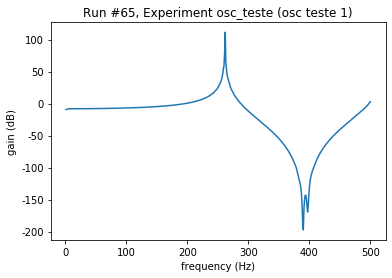

In [28]:
plot_dataset(dataset)